In [323]:
import matutils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#from tensorflow import keras
from Bio import SeqIO
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import cooler
from tqdm import tqdm
#import keras.backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, Dot, Activation, Flatten, Add, Concatenate, Lambda, BatchNormalization, Permute, RepeatVector, Multiply, UpSampling2D, Average
from keras.models import Model, model_from_json
import keras.backend as K
from keras.initializers import glorot_uniform


from numpy import asarray
from numpy import savez_compressed
from numpy import load

In [3]:
def one_hot(seq):
    seq_array = np.array(list(seq))
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq.reshape( -1, 1))
    onehot_encoded_seq = onehot_encoded_seq.reshape(onehot_encoded_seq.shape[0],-1,1 )
    onehot_encoded_seq = onehot_encoded_seq.astype('uint8')
    return onehot_encoded_seq

In [6]:
cool_path = '/media/lchumpitaz/New Volume/work/programas/Data/Hi-C/mcools/GM12878_inSitu_MboI.hg19.mapq_30.1000.mcool'
fasta_path = '/media/lchumpitaz/New Volume/work/programas/Data/Hi-C/hg19.fa'

In [7]:
c = cooler.Cooler(cool_path + '::/resolutions/1000')

In [8]:
arr = c.matrix(balance = True)[1000:1050,1000:1050]

/home/lchumpitaz/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


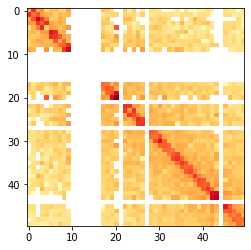

In [9]:
plt.imshow(np.log(arr), cmap = 'YlOrRd')

In [10]:
def get_data( cool, records, win_size = 1000, examples = 10000):
    
    global x_train, y_train
    
    bins = c.bins()[:]
    max_examples = bins.index[-1] - win_size + 1
    
    exam = np.random.choice(range(max_examples) , examples, replace = False)
    
    np.random.shuffle(exam)
    
    index = 0
    for i in tqdm(exam):
        
        if index == len(x_train):
            break
        curr_bins = bins.iloc[i: i+win_size]
        
        if len(curr_bins[curr_bins['weight'] == curr_bins['weight']]) < win_size:
            continue
        
        sequence = ''
        for chrom in curr_bins['chrom'].unique():
            seq_start = curr_bins[curr_bins.chrom == chrom].iloc[0]['start']
            seq_end = curr_bins[curr_bins.chrom == chrom].iloc[-1]['end']
            for record in records:
                if record.id == chrom:
                    sequence += str(record.seq[seq_start:seq_end]).upper()
                    continue
        
        if 'N' in sequence:
            continue
        
        
        bin_start = curr_bins.index[0]
        bin_end = curr_bins.index[-1]+1
        
        arr = c.matrix(balance = True)[bin_start:bin_end,bin_start:bin_end]
        x_train[index] = one_hot(sequence)
        y_train[index] = arr
        index +=1
    return index
    

In [12]:
try:
    x_train = load('x_train.npz')['arr_0']
    y_train = load('y_train.npz')['arr_0']
except:
    records = list(SeqIO.parse(fasta_path,"fasta"))
    x_train = np.zeros((3000, 520000, 4, 1), dtype = 'uint8')
    y_train = np.zeros((3000, 520, 520), dtype = np.float32)
    N = get_data(c, records, win_size = 520, examples = 3000000)
    x_train = x_train[:N]
    y_train = y_train[:N]
    savez_compressed('x_train.npz', x_train)
    savez_compressed('y_train.npz', y_train)

100%|██████████| 3000000/3000000 [42:22<00:00, 1180.13it/s]


In [14]:
N

400

In [10]:
#np.save('x_train.npy',x_train) about 200gb of data

In [11]:
#np.save('y_train.npy', maps)

/home/lchumpitaz/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


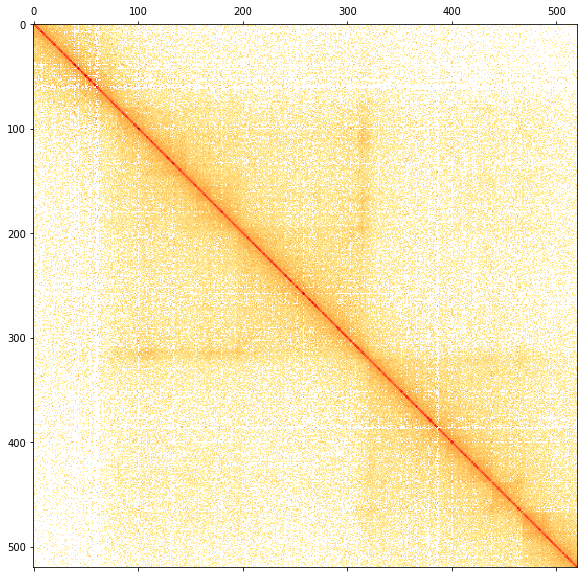

In [499]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(y_train[30]), cmap='YlOrRd');

In [351]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, 1), padding='valid', name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, 1), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, 1), padding='valid', name=conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###
    return X

In [506]:
K.clear_session()

In [582]:
def seq_to_signal():
    input_seq= Input(shape= (500000, 4, 1))
    x = Conv2D(256, (10, 4), strides = (1, 4), padding = 'same')(input_seq)
    
    x = convolutional_block(x, f = 2, filters = [32, 32, 64], stage = 1, block = 'a', s=2)
    x = convolutional_block(x, f = 5, filters = [64, 64, 128], stage = 1, block = 'b', s=5)
    x = convolutional_block(x, f = 2, filters = [64, 64, 128], stage = 1, block = 'c', s=2)
    x = convolutional_block(x, f = 5, filters = [128, 128, 256], stage = 1, block = 'd', s=5)
    x = convolutional_block(x, f = 2, filters = [128, 128, 256], stage = 1, block = 'e', s=2)
    x = convolutional_block(x, f = 5, filters = [256, 256, 512], stage = 1, block = 'f', s=5)

    
    model = Model(input_seq, x)
    return model

In [583]:
def signal_to_map():
    
    inp1 = Input(shape = (500, 1, 512))
    inp2 = Input(shape = (500, 1, 512))

    
    s1 = Lambda( lambda l : K.tile(l ,(1, 1,500, 1)))(inp1)
    
    s2 = Lambda( lambda l : K.tile(l ,(1, 1,500, 1)))(inp2)
    
    s2 = Permute((2, 1, 3))(s2)
    
    y = Multiply()([s1, s2])
    
    y = Lambda( lambda l : K.sum(l, axis = 3, keepdims = True))(y)
    
    #y = Conv2D(128, (3, 3), activation='relu', padding='same')(y)
    #y = UpSampling2D((2, 2))(y)
    
    #y = Conv2D(64, (3, 3), activation='relu', padding='same')(y)
    #y = Conv2D(1, (1, 1), activation='relu', padding='same')(y)
    
    #y = Reshape((500, 500))(y)
    
    model = Model(inputs = [inp1, inp2], outputs = y)
    
    return model
    
    
    
    

In [584]:
signal_model = seq_to_signal()

In [585]:
signal_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 500000, 4, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 500000, 1, 25 10496       input_25[0][0]                   
__________________________________________________________________________________________________
res1a_branch2a (Conv2D)         (None, 250000, 1, 32 8224        conv2d_6[0][0]                   
__________________________________________________________________________________________________
bn1a_branch2a (BatchNormalizati (None, 250000, 1, 32 128         res1a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

In [586]:
mat_model = signal_to_map()

In [587]:
mat_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 500, 1, 512)  0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 500, 1, 512)  0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 500, 500, 512 0           input_27[0][0]                   
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 500, 500, 512 0           input_26[0][0]                   
__________________________________________________________________________________________________
permute_6 

In [588]:
seq1= Input(shape= (500000, 4, 1))
#seq2= Input(shape= (500000, 4, 1))

sm = signal_model(seq1)

M = mat_model([sm, sm])



model = Model(inputs = seq1, outputs = M)


In [589]:
'''
try:    
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("model.h5")
    print("Loaded model from disk")
except:
    print('not working')
    '''

'\ntry:    \n    json_file = open(\'model.json\', \'r\')\n    loaded_model_json = json_file.read()\n    json_file.close()\n    model = model_from_json(loaded_model_json)\n    # load weights into new model\n    model.load_weights("model.h5")\n    print("Loaded model from disk")\nexcept:\n    print(\'not working\')\n    '

In [590]:
model.compile(optimizer = 'nadam', loss='mse', metrics = ['accuracy'])

In [591]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 500000, 4, 1) 0                                            
__________________________________________________________________________________________________
model_17 (Model)                (None, 500, 1, 512)  1124288     input_28[0][0]                   
__________________________________________________________________________________________________
model_18 (Model)                (None, 500, 500, 1)  0           model_17[1][0]                   
                                                                 model_17[1][0]                   
Total params: 1,124,288
Trainable params: 1,116,224
Non-trainable params: 8,064
__________________________________________________________________________________________________


In [592]:
def slide_input(x, index):
    if index > 19:
        print('Invalid')
        return None
    return x[:, index*1000:-(20 - index)*1000]

In [593]:
def slide_output(y, index1, index2):
    if index1 > 19 or index2 > 19:
        print('Invalid')
        return None
    return y[:, index1:-(20 - index1), index2:-(20 - index2)]

In [595]:
for i in range(5, 15):
    model.fit(slide_input(x_train, index = i), 
              slide_output(y_train, index1 = i, index2 = i)[:,:,:, None], batch_size = 1, epochs = 200) 

Epoch 1/200
400/400 [==============================] - 96s 240ms/step - loss: 0.0762 - acc: 0.3225
Epoch 2/200
400/400 [==============================] - 96s 240ms/step - loss: 0.0329 - acc: 0.3313
Epoch 3/200
400/400 [==============================] - 96s 240ms/step - loss: 0.0181 - acc: 0.3333
Epoch 4/200
400/400 [==============================] - 96s 240ms/step - loss: 0.0108 - acc: 0.3341
Epoch 5/200
400/400 [==============================] - 96s 240ms/step - loss: 0.0068 - acc: 0.3345
Epoch 6/200
400/400 [==============================] - 96s 240ms/step - loss: 0.0046 - acc: 0.3347
Epoch 7/200
400/400 [==============================] - 96s 241ms/step - loss: 0.0032 - acc: 0.3349
Epoch 8/200
400/400 [==============================] - 96s 241ms/step - loss: 0.0023 - acc: 0.3349
Epoch 9/200
400/400 [==============================] - 96s 240ms/step - loss: 0.0017 - acc: 0.3350
Epoch 10/200
400/400 [==============================] - 95s 237ms/step - loss: 0.0012 - acc: 0.3350
Epoch 11/

400/400 [==============================] - 92s 231ms/step - loss: 2.3355e-05 - acc: 0.3350
Epoch 81/200
400/400 [==============================] - 92s 231ms/step - loss: 2.3324e-05 - acc: 0.3350
Epoch 82/200
400/400 [==============================] - 92s 231ms/step - loss: 2.3322e-05 - acc: 0.3350
Epoch 83/200
400/400 [==============================] - 92s 231ms/step - loss: 2.3307e-05 - acc: 0.3350
Epoch 84/200
400/400 [==============================] - 92s 231ms/step - loss: 2.3291e-05 - acc: 0.3350
Epoch 85/200
400/400 [==============================] - 92s 231ms/step - loss: 2.3258e-05 - acc: 0.3350
Epoch 86/200
400/400 [==============================] - 92s 231ms/step - loss: 2.3307e-05 - acc: 0.3350
Epoch 87/200
400/400 [==============================] - 92s 231ms/step - loss: 2.3235e-05 - acc: 0.3350
Epoch 88/200
400/400 [==============================] - 92s 231ms/step - loss: 2.3638e-05 - acc: 0.3350
Epoch 89/200
400/400 [==============================] - 92s 231ms/step - loss

400/400 [==============================] - 92s 231ms/step - loss: 7.4619e-06 - acc: 0.3350
Epoch 159/200
400/400 [==============================] - 92s 231ms/step - loss: 7.4772e-06 - acc: 0.3350
Epoch 160/200
400/400 [==============================] - 92s 231ms/step - loss: 7.4258e-06 - acc: 0.3350
Epoch 161/200
400/400 [==============================] - 92s 231ms/step - loss: 7.4014e-06 - acc: 0.3350
Epoch 162/200
400/400 [==============================] - 92s 231ms/step - loss: 7.4009e-06 - acc: 0.3350
Epoch 163/200
400/400 [==============================] - 92s 231ms/step - loss: 7.3980e-06 - acc: 0.3350
Epoch 164/200
400/400 [==============================] - 92s 231ms/step - loss: 7.3743e-06 - acc: 0.3350
Epoch 165/200
400/400 [==============================] - 92s 231ms/step - loss: 7.3758e-06 - acc: 0.3350
Epoch 166/200
400/400 [==============================] - 92s 231ms/step - loss: 7.3504e-06 - acc: 0.3350
Epoch 167/200
400/400 [==============================] - 92s 231ms/st

400/400 [==============================] - 92s 231ms/step - loss: 6.8808e-06 - acc: 0.3349
Epoch 37/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8819e-06 - acc: 0.3349
Epoch 38/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8770e-06 - acc: 0.3349
Epoch 39/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8773e-06 - acc: 0.3349
Epoch 40/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8735e-06 - acc: 0.3349
Epoch 41/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8749e-06 - acc: 0.3349
Epoch 42/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8673e-06 - acc: 0.3349
Epoch 43/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8726e-06 - acc: 0.3349
Epoch 44/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8743e-06 - acc: 0.3349
Epoch 45/200
400/400 [==============================] - 92s 231ms/step - loss

400/400 [==============================] - 92s 231ms/step - loss: 6.8327e-06 - acc: 0.3349
Epoch 115/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8313e-06 - acc: 0.3349
Epoch 116/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8340e-06 - acc: 0.3349
Epoch 117/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8326e-06 - acc: 0.3349
Epoch 118/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8304e-06 - acc: 0.3349
Epoch 119/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8314e-06 - acc: 0.3349
Epoch 120/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8335e-06 - acc: 0.3349
Epoch 121/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8314e-06 - acc: 0.3349
Epoch 122/200
400/400 [==============================] - 92s 231ms/step - loss: 6.8305e-06 - acc: 0.3349
Epoch 123/200
400/400 [==============================] - 92s 231ms/st

KeyboardInterrupt: 

In [603]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [596]:
signals = signal_model.predict(slide_input(x_train, index = 5), batch_size = 2)

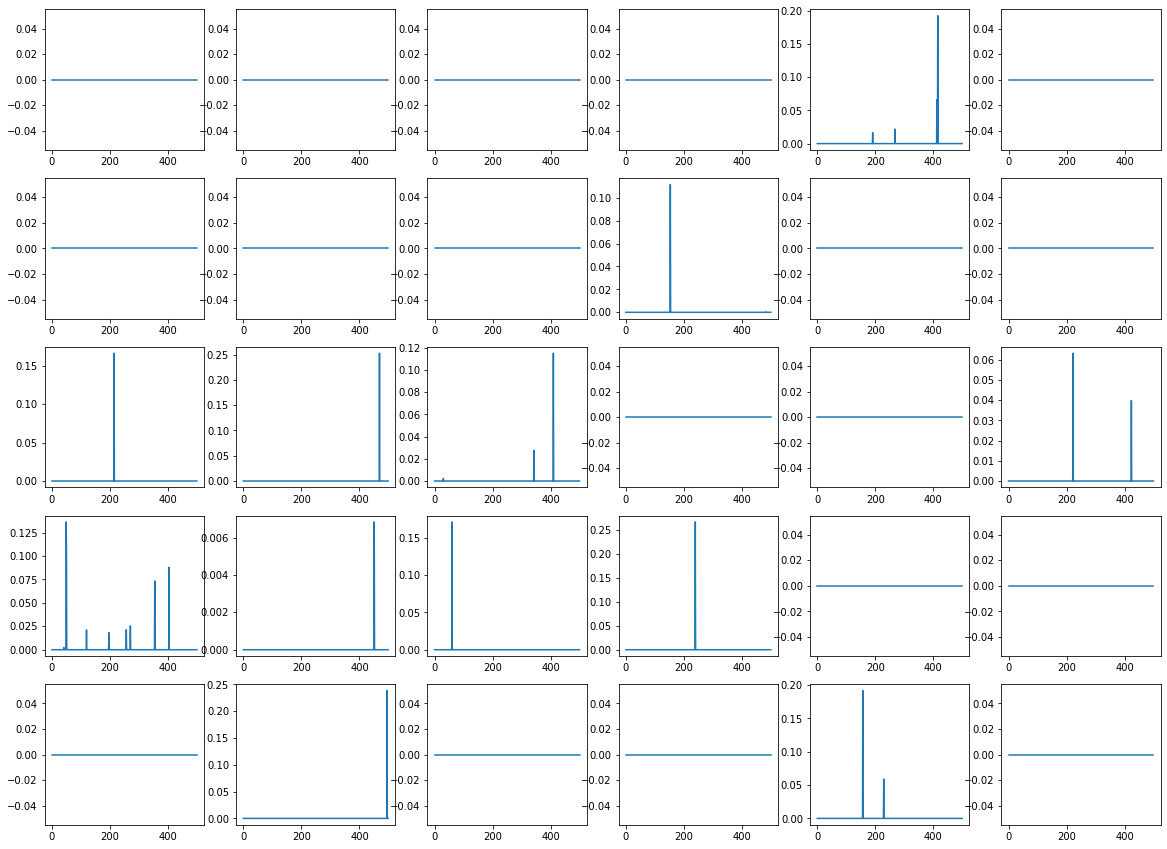

In [597]:
plt.figure(figsize = (20, 15))
for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.plot(signals[0,:, 0, i]);

In [598]:
predictions = model.predict(slide_input(x_train, index = 5), batch_size = 2)[:,:,:,0]

In [599]:
#signals = x.predict(x_train, batch_size = 1)

# Predictions, Really BAD so far

/home/lchumpitaz/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/lchumpitaz/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


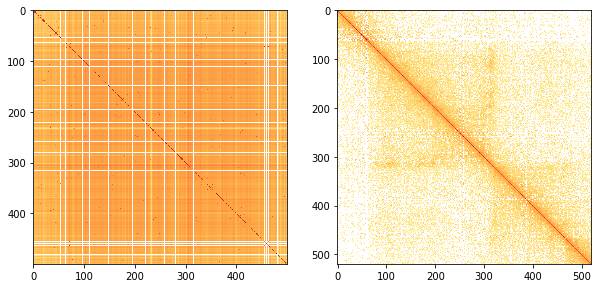

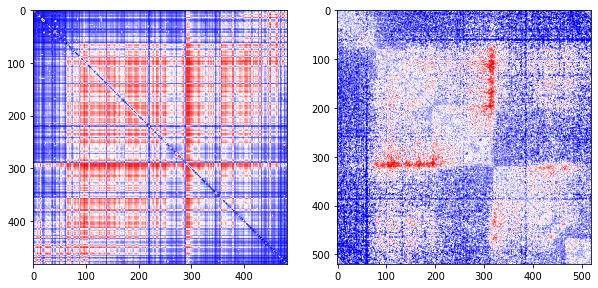

In [602]:
i = 30
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(np.log10(predictions[i] ), cmap='YlOrRd', interpolation = 'none')
plt.subplot(122)
plt.imshow(np.log10(y_train[i]),cmap='YlOrRd');

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(np.tanh(matutils.enrichment(predictions[i]) -1), cmap='bwr', interpolation = 'bilinear')
plt.subplot(122)
plt.imshow(np.tanh(matutils.enrichment(y_train[i]) -1),cmap='bwr', interpolation = 'bilinear');